In [1]:
import numpy as np
from scipy.linalg import toeplitz, sqrtm
import cvxpy as cp
import matplotlib.pyplot as plt

In this work, I try to implement the calculation of from Prof. Gustafsson and al. - "Tutorial on antenna current optimization using MATLAB and CVX", section 7. A thin strip dipole with dimensions $x$, $y$ divided into $Nx = 16$ rectangular mesh elements.

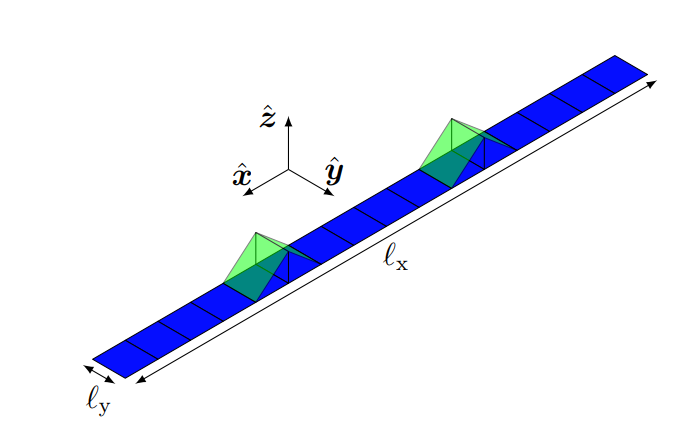

### Parametrers

In [2]:
eta0 = 299792458 * 4e-7*np.pi # free space impedance
kl = 0.48 * 2*np.pi # wavenumber,0.48lambda
Nx = 16 # number of elements
N = Nx - 1 # number of unknowns
dx = 1/Nx # rectangle length
dy = 0.02 # rectangle width
x = 0.48*np.array([i for i in range(N)])/(N-1) - 0.48/2

### Precalculated E−energy, M−energy, and Radiated power

E−energy

In [3]:
Xe11 = 1e3*np.array([1.14,-0.4485,-0.0926,-0.0153,-0.0059,-0.0030,-0.0018,-0.0013,-0.0009,-0.0008,-0.0007,-0.0006,-0.0005,-0.0005,-0.0004])
Xe = toeplitz(Xe11) 

M−energy

In [4]:
Xm11 = 10*np.array([1.8230,0.8708,0.2922,0.1664,0.1060,0.0680,0.0411,0.0208,0.0050,-0.0074,-0.0171,-0.0244,-0.0297,-0.0332,-0.0351])
Xm = toeplitz(Xm11) # M−energy

Radiated power

In [5]:
Rr11 = 0.1*np.array([7.0919,7.0668,6.9918,6.8680,6.6974,6.4824,6.2264,5.9331,5.6067,5.2521,4.8744,4.4788,4.0707,3.6558,3.2393])
Rr = toeplitz(Rr11)+np.eye(N, dtype=float)*2e-5

### Far field vector

In [6]:
F = eta0*(-1j*kl)/4/np.pi*np.ones([1,N])*dx 

## CVX optimization using quadratic form

From the reference, we get the convex optimization problem to minimize the stored energy for a fixed far-field in one direction and polarization as follows

$$
\begin{aligned}
\textrm{minimize} \quad & \max(I^HX_eI,I^HX_mI)\\
\textrm{s.t.} \quad & FI = -j\\
\end{aligned}
$$

or reformulated as

$$
\begin{aligned}
\textrm{minimize} \quad & w\\
\textrm{s.t.} \quad & I^HX_eI \le w \\
                    & I^HX_mI\le w \\
                    & FI = -j\\
\end{aligned}
$$

In [7]:
# Define and solve the CVXPY problem.
w = cp.Variable(1)
I = cp.Variable(N)
prob = cp.Problem(cp.Minimize(w),
                 [cp.quad_form(I, Xe) <= w,
                  cp.quad_form(I, Xm) <= w,
                 F @ I == -1j])
prob.solve()

0.1047036101952615

In [8]:
# Print result.
print("\nThe optimal value is", prob.value)
print("A solution w is")
print(w.value)
print("A solution I is")
print(I.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)


The optimal value is 0.1047036101952615
A solution w is
[0.10470361]
A solution I is
[0.00544208 0.00852805 0.01085947 0.01256558 0.01378651 0.01460581
 0.01507736 0.01523154 0.01507736 0.01460581 0.01378651 0.01256558
 0.01085947 0.00852805 0.00544208]
A dual solution corresponding to the inequality constraints is
[0.48755244]


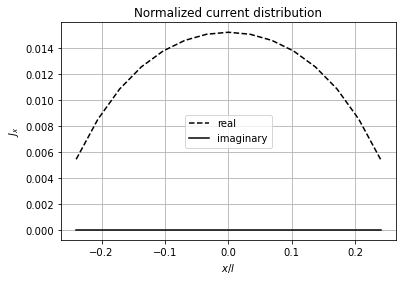

In [9]:
plt.plot(x, np.real(I.value), '--', color='black', label='real')
plt.plot(x, np.imag(I.value), color='black', label='imaginary')
plt.grid()
plt.xlabel("$x/l$") 
plt.ylabel("$J_x$") 
plt.legend()
plt.title('Normalized current distribution')
plt.show()

## Antenna parameters from the max. 

### G/Q problem

In [10]:
P = np.abs(F@I.value)*np.abs(F@I.value)/2/eta0 # radiation intensity
Pr = np.real(I.value.T@Rr@I.value)/2 # radiated power
D = 4*np.pi*P/Pr # res. directivity
We = np.real(I.value.T@Xe@I.value)/4/kl # stored E energy
Wm = np.real(I.value.T@Xm@I.value)/4/kl # stored M energy
W = max(We,Wm) # stored energy
Q = 2*kl*W/Pr  # Q
Qe = 2*kl*We/Pr # Q electric
Qm = 2*kl*Wm/Pr # Q magnetic

Results of the optimization

In [11]:
print("Directivity:")
print(D)
print("Quality Factor:")
print(Q)
print("QF electric:")
print(Qe)
print("QF magnetic:")
print(Qm)

Directivity:
[1.6529984]
Quality Factor:
5.1886597042864775
QF electric:
5.1886597042864775
QF magnetic:
5.1886505350279295


## CVX optimization using norm

It's preferable to use $\lVert X_e^{1/2}I\lVert^2 = I^HX_eI$ to replace the quadratic forms $quad\_form(I,Xe)$ with norms $norm(sqrtXe*I)$ in CVX , where $sqrtXe=sqrtm(Xe)$.

The problem is therefore equally

$$
\begin{aligned}
\textrm{minimize} \quad & w\\
\textrm{s.t.} \quad & \lVert sqrtX_eI\lVert \le w \\
                    & \lVert sqrtX_mI\lVert\le w \\
                    & FI = -j\\
\end{aligned}
$$

In [12]:
sqrtXe = sqrtm(Xe)
sqrtXm = sqrtm(Xm)

### Reformulate of the G/Q problem

In [13]:
# Define and solve the CVXPY problem.
w = cp.Variable(1)
I = cp.Variable(N)
prob = cp.Problem(cp.Minimize(w),
                 [cp.norm(sqrtXe @ I) <= w,
                  cp.norm(sqrtXm @ I) <= w,
                 F @ I == -1j])
prob.solve()

0.3235793730308847

Remark that w in this case is the square-root of the previous optimization.

In [14]:
# Print result.
print("\nThe optimal value is", prob.value)
print("A solution w is")
print(w.value**2)
print("A solution I is")
print(I.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)


The optimal value is 0.3235793730308847
A solution w is
[0.10470361]
A solution I is
[0.00544208 0.00852801 0.01085942 0.01256556 0.01378653 0.01460584
 0.01507739 0.01523157 0.01507739 0.01460584 0.01378653 0.01256556
 0.01085942 0.008528   0.00544208]
A dual solution corresponding to the inequality constraints is
[0.48743014]


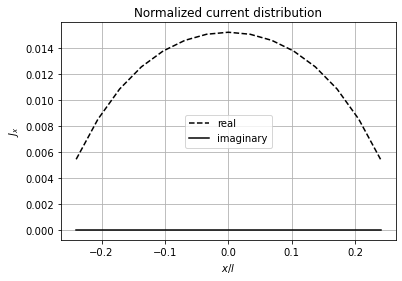

In [15]:
plt.plot(x, np.real(I.value), '--', color='black', label='real')
plt.plot(x, np.imag(I.value), color='black', label='imaginary')
plt.grid()
plt.xlabel("$x/l$") 
plt.ylabel("$J_x$") 
plt.legend()
plt.title('Normalized current distribution')
plt.show()

## Superdirective antenna

Superdirective antennas have a higher directivity than a typical antenna of the same size. It's proved that the partial directivity is at least $D_0$ if

$$D_0 \le D = \frac{4|\hat e^*.F(\hat r)|^2}{2\eta_0 P_r} \Rightarrow P_r \le \frac{2|\hat e^*.F(\hat r)|^2}{\eta_0 P_r D_0}$$ 

We can therefore add an the convex constraint $1/2 I^H R_rI \le 2\pi/(\eta_0 D_0)$ to the optimization problem giving

$$
\begin{aligned}
\textrm{minimize} \quad & \max(I^HX_eI,I^HX_mI)\\
\textrm{s.t.} \quad & FI = -j\\
  &I^HR_rI\le\frac{4\pi}{2\eta_0 D_0}    \\
\end{aligned}
$$

For example, let's calculate the upper Q-Factor for the examined dipole for a directivity of 2. 

In [16]:
D0 = 2

In [17]:
# Define and solve the CVXPY problem.
w = cp.Variable(1)
I = cp.Variable(N)
prob = cp.Problem(cp.Minimize(w),
                 [cp.quad_form(I, Xe) <= w,
                  cp.quad_form(I, Xm) <= w,
                  F @ I == -1j,
                  cp.quad_form(I,Rr) <= 4*np.pi/D0/eta0]) # radiated power
prob.solve()

C:\Users\knguyen\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2.6713499799632516

With the wanning, it seems that the optimisation is not at its best efficiency. It can be improved by using $norm(Xe)$ like previously showed.

In [18]:
# Define and solve the CVXPY problem.
w = cp.Variable(1)
I = cp.Variable(N)
prob = cp.Problem(cp.Minimize(w),
                 [cp.norm(sqrtXe @ I) <= w,
                  cp.norm(sqrtXm @ I) <= w,
                  F @ I == -1j,
                  cp.quad_form(I,Rr) <= 4*np.pi/D0/eta0]) # radiated power])
prob.solve()

1.634424857734263

In [19]:
# Print result.
print("\nThe optimal value is", prob.value)
print("A solution w is")
print(w.value**2)
print("A solution I is")
print(I.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)


The optimal value is 1.634424857734263
A solution w is
[2.67134462]
A solution I is
[ 0.03190707  0.03551033  0.02912313  0.01741243  0.00443637 -0.00687343
 -0.01446874 -0.01713307 -0.01446874 -0.00687343  0.00443637  0.01741243
  0.02912313  0.03551033  0.03190707]
A dual solution corresponding to the inequality constraints is
[0.99999929]


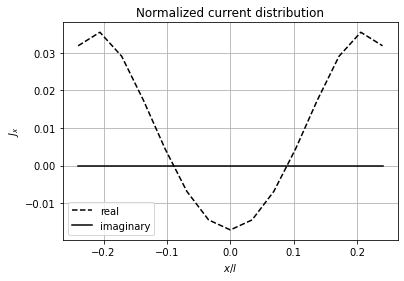

In [20]:
plt.plot(x, np.real(I.value), '--', color='black', label='real')
plt.plot(x, np.imag(I.value), color='black', label='imaginary')
plt.grid()
plt.xlabel("$x/l$") 
plt.ylabel("$J_x$") 
plt.legend()
plt.title('Normalized current distribution')
plt.show()

In [21]:
P = np.abs(F@I.value)*np.abs(F@I.value)/2/eta0 # radiation intensity
Pr = np.real(I.value.T@Rr@I.value)/2 # radiated power
D = 4*np.pi*P/Pr # res. directivity
We = np.real(I.value.T@Xe@I.value)/4/kl # stored E energy
Wm = np.real(I.value.T@Xm@I.value)/4/kl # stored M energy
W = max(We,Wm) # stored energy
Q = 2*kl*W/Pr  # Q
Qe = 2*kl*We/Pr # Q electric
Qm = 2*kl*Wm/Pr # Q magnetic

In [22]:
print("Directivity:")
print(D)
print("Quality Factor:")
print(Q)
print("QF electric:")
print(Qe)
print("QF magnetic:")
print(Qm)

Directivity:
[1.99999948]
Quality Factor:
160.16964744942442
QF electric:
160.16964744942442
QF magnetic:
15.065862433969198


The Q-factor is increased to $Q = Qe \approx160$ for $D = 2$ in comparison with $Q \approx5$ for the $G/Q$ case with $D \approx1.65$

## Embedded antennas

Current optimization is easily generalized to the case of antennas embedded into a (PEC) ground plane. The current density is then decomposed into the controllable current $I_A$, and the induced current $I_G$. Similarly, the region is divided into $\Omega_A$, the antenna structure, and $\Omega_G$, the ground plane. In $\Omega_A$ we can fully control the currents $I_A$, that in turn induce $I_G$ in $\Omega_G$. We use that Maxwell’s equations are linear implying that $I_G$ depends linearly on $I_A$.

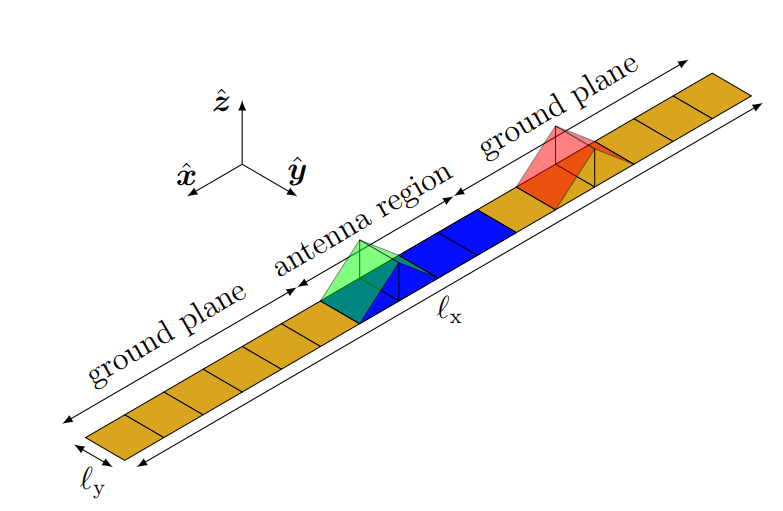

Antenna region in the center of a strip dipole

In [23]:
Nf = 7 # start of antenna region
indA = np.array([i for i in range(Nf-1,(N-Nf+1))]) # antenna region indices
indG = np.array([[i for i in range(Nf-1)] + [i for i in range((N-Nf+1),N)]]) # ground plane indices
Zm = Rr + 1j*(Xm - Xe) # EFIE impedance matrix
Cm = np.squeeze(Zm[indG,:]) # induced current Cm*I=0

The constraint $CI = 0$ is added to the $G=Q$ optimization problem giving the convex optimization problem

$$
\begin{aligned}
\textrm{minimize} \quad & w\\
\textrm{s.t.} \quad & I^HX_eI \le w \\
                    & I^HX_mI\le w \\
                    & FI = -j\\
                    & CI = 0\\
\end{aligned}
$$

Because the CVXPY can add only 3 conditions, we can unite the last two terms into one.

In [32]:
F_Cm = np.concatenate((F,Cm), axis=0)
b = np.array([[-1j] + [0 for i in range(Cm.shape[0])]])

In [33]:
# Define and solve the CVXPY problem.
w = cp.Variable(1)
I = cp.Variable(N)
prob = cp.Problem(cp.Minimize(w),
                 [cp.quad_form(I, Xe) <= w,
                  cp.quad_form(I, Xm) <= w,
                  F_Cm @ I == b])
prob.solve()

ValueError: Cannot broadcast dimensions  (13,) (1, 13)

In [26]:
F_Cm.shape

(13, 15)

In [34]:
F.shape

(1, 15)

In [28]:
Cm

array([[0.70921-1.12177e+03j, 0.70668+4.57208e+02j, 0.69918+9.55220e+01j,
        0.6868 +1.69640e+01j, 0.66974+6.96000e+00j, 0.64824+3.68000e+00j,
        0.62264+2.21100e+00j, 0.59331+1.50800e+00j, 0.56067+9.50000e-01j,
        0.52521+7.26000e-01j, 0.48744+5.29000e-01j, 0.44788+3.56000e-01j,
        0.40707+2.03000e-01j, 0.36558+1.68000e-01j, 0.32393+4.90000e-02j],
       [0.70668+4.57208e+02j, 0.70921-1.12177e+03j, 0.70668+4.57208e+02j,
        0.69918+9.55220e+01j, 0.6868 +1.69640e+01j, 0.66974+6.96000e+00j,
        0.64824+3.68000e+00j, 0.62264+2.21100e+00j, 0.59331+1.50800e+00j,
        0.56067+9.50000e-01j, 0.52521+7.26000e-01j, 0.48744+5.29000e-01j,
        0.44788+3.56000e-01j, 0.40707+2.03000e-01j, 0.36558+1.68000e-01j],
       [0.69918+9.55220e+01j, 0.70668+4.57208e+02j, 0.70921-1.12177e+03j,
        0.70668+4.57208e+02j, 0.69918+9.55220e+01j, 0.6868 +1.69640e+01j,
        0.66974+6.96000e+00j, 0.64824+3.68000e+00j, 0.62264+2.21100e+00j,
        0.59331+1.50800e+00j, 0.5606

In [29]:
F_Cm

array([[0.     -5.6509547e+00j, 0.     -5.6509547e+00j,
        0.     -5.6509547e+00j, 0.     -5.6509547e+00j,
        0.     -5.6509547e+00j, 0.     -5.6509547e+00j,
        0.     -5.6509547e+00j, 0.     -5.6509547e+00j,
        0.     -5.6509547e+00j, 0.     -5.6509547e+00j,
        0.     -5.6509547e+00j, 0.     -5.6509547e+00j,
        0.     -5.6509547e+00j, 0.     -5.6509547e+00j,
        0.     -5.6509547e+00j],
       [0.70921-1.1217700e+03j, 0.70668+4.5720800e+02j,
        0.69918+9.5522000e+01j, 0.6868 +1.6964000e+01j,
        0.66974+6.9600000e+00j, 0.64824+3.6800000e+00j,
        0.62264+2.2110000e+00j, 0.59331+1.5080000e+00j,
        0.56067+9.5000000e-01j, 0.52521+7.2600000e-01j,
        0.48744+5.2900000e-01j, 0.44788+3.5600000e-01j,
        0.40707+2.0300000e-01j, 0.36558+1.6800000e-01j,
        0.32393+4.9000000e-02j],
       [0.70668+4.5720800e+02j, 0.70921-1.1217700e+03j,
        0.70668+4.5720800e+02j, 0.69918+9.5522000e+01j,
        0.6868 +1.6964000e+01j, 0.6697

In [31]:
b.T

array([-0.-1.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j])